In [1]:
# 导入常用库
import numpy as np
import tensorflow as tf
import keras 
import cv2
import pandas as pd
import sklearn
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets

# import h5py

import pickle
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

/home/kunni/anaconda3/envs/python35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


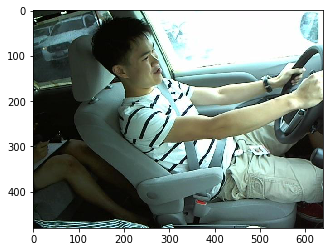

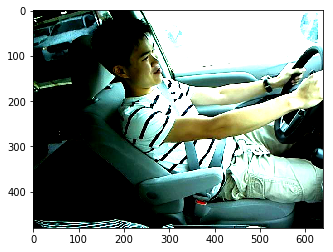

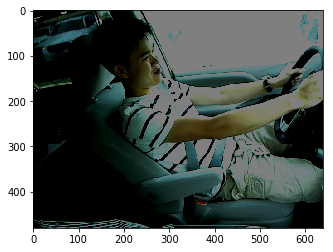

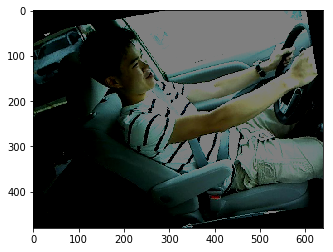

In [2]:
from PIL import Image, ImageEnhance

csv = pd.read_csv('./driver_imgs_list.csv')
csv['img'] = './imgs/train/' + csv['classname'] + '/' + csv['img']
filename = csv.iloc[0,2]

img = Image.open(filename)
plt.figure(1)
plt.imshow(np.asarray(img))
img = ImageEnhance.Contrast(img).enhance(2)
plt.figure(2)
plt.imshow(np.asarray(img))
img = ImageEnhance.Brightness(img).enhance(0.5)
plt.figure(3)
plt.imshow(np.asarray(img))
img = img.rotate(10)
plt.figure(4)
plt.imshow(np.asarray(img))


In [13]:
%%time
# data augmentation
# contrast, brightness, rotation, random patch
csv = pd.read_csv('./driver_imgs_list.csv')
csv['img'] = './imgs/train/' + csv['classname'] + '/' + csv['img']

from PIL import Image, ImageEnhance, ImageDraw
from multiprocessing import Pool
import random 

# # ieration nums of augmentation
# aug_iteration = 1

# augmentation
# def subAugment(img, filename, idx):
#     img_copy = img.copy()
#     alpha = random.uniform(1.0, 2.5)
#     beta = random.uniform(0.8,1.5)
#     img_copy = ImageEnhance.Contrast(img_copy).enhance(alpha) # contrast
#     img_copy = ImageEnhance.Brightness(img_copy).enhance(beta) # brightness
#     angle = random.uniform(-10,10)
#     img_copy = img_copy.rotate(angle) # ratation
#     patch_size = 80
#     width, height = img_copy.size
#     draw = ImageDraw.Draw(img_copy)
#     patch_num = 2
#     for j in range(patch_num):
#         center_x = random.uniform(patch_size / 2., width - patch_size / 2.)
#         center_y = random.uniform(patch_size / 2., height - patch_size / 2.)
#         xy = [center_x - patch_size / 2., center_y - patch_size / 2., center_x + patch_size / 2., center_y + patch_size / 2.]
#         draw.rectangle(xy, fill=(0,0,0))
    
    
#     class_name = filename.split('/')[-2]
#     img_path = filename.split('/')[-1].split('.')[-2] + '_' + str(idx) + '.jpg'
#     save_path = './imgs_aug/' + class_name + '/' + img_path
#     img_copy.save(save_path)

# def augment(filename):
#     img = Image.open(filename)
#     for i in range(aug_iteration):
#         subAugment(img, filename, i)
    
# with Pool(12) as p:
#     p.map(augment, csv['img'])

# # create new csv file
# raw_len = len(csv)
# new_csv = csv.copy() # also use raw data
# for i in range(raw_len):
#     driver = csv.iloc[i,0]
#     class_name = csv.iloc[i,1]
#     file_name = csv.iloc[i,2]
#     for i in range(aug_iteration):
#         img_path = file_name.split('/')[-1].split('.')[-2] + '_' + str(i) + '.jpg'
#         save_path = './imgs_aug/' + class_name + '/' + img_path
#         new_csv = new_csv.append(pd.DataFrame([[driver, class_name, save_path]], columns=['subject','classname','img']))

# new_csv = new_csv.reset_index(drop=True)
# new_csv.to_csv('./driver_imgs_list_aug.csv', index = False)


raw_len = len(csv)
new_csv = csv.copy() # also use raw data
for i in range(raw_len):
#     import ipdb; ipdb.set_trace()
    driver = csv.iloc[i,0]
    class_name = csv.iloc[i,1]
    file_name = csv.iloc[i,2]
    raw_img = Image.open(file_name)
    mix_img_path = csv[csv['classname'] == class_name][csv['subject'] != driver].sample(n=1)['img'].iloc[0]
    mix_img = Image.open(mix_img_path)
    width, height = raw_img.size
    combined_img = Image.new('RGB', (width, height))
#     import ipdb; ipdb.set_trace()
    combined_img.paste(mix_img.crop((0,0,240,height)), (0,0))
    combined_img.paste(raw_img.crop((240,0,width,height)), (240,0))
    img_path = file_name.split('/')[-1].split('.')[-2] + '_1.jpg'
    save_path = './imgs_aug/' + class_name + '/' + img_path
    combined_img.save(save_path)
    new_csv = new_csv.append(pd.DataFrame([[driver, class_name, save_path]], columns=['subject','classname','img']))

new_csv = new_csv.reset_index(drop=True)
new_csv.to_csv('./driver_imgs_list_aug.csv', index = False)



/home/kunni/anaconda3/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 11min 12s, sys: 1.82 s, total: 11min 13s
Wall time: 11min 14s


  subject classname                            img
0    p002        c0  ./imgs/train/c0/img_44733.jpg
1    p002        c0  ./imgs/train/c0/img_72999.jpg
2    p002        c0  ./imgs/train/c0/img_25094.jpg
3    p002        c0  ./imgs/train/c0/img_69092.jpg
4    p002        c0  ./imgs/train/c0/img_92629.jpg
原始训练集样本数为：22424
原始训练集司机人数为：26
原始训练集行为类别数为：10
      subject classname                            img
13980    p049        c4  ./imgs/train/c4/img_53559.jpg
(480, 640, 3)


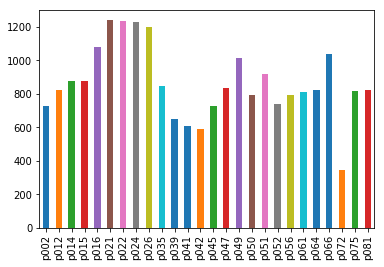

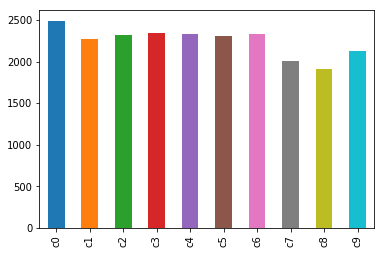

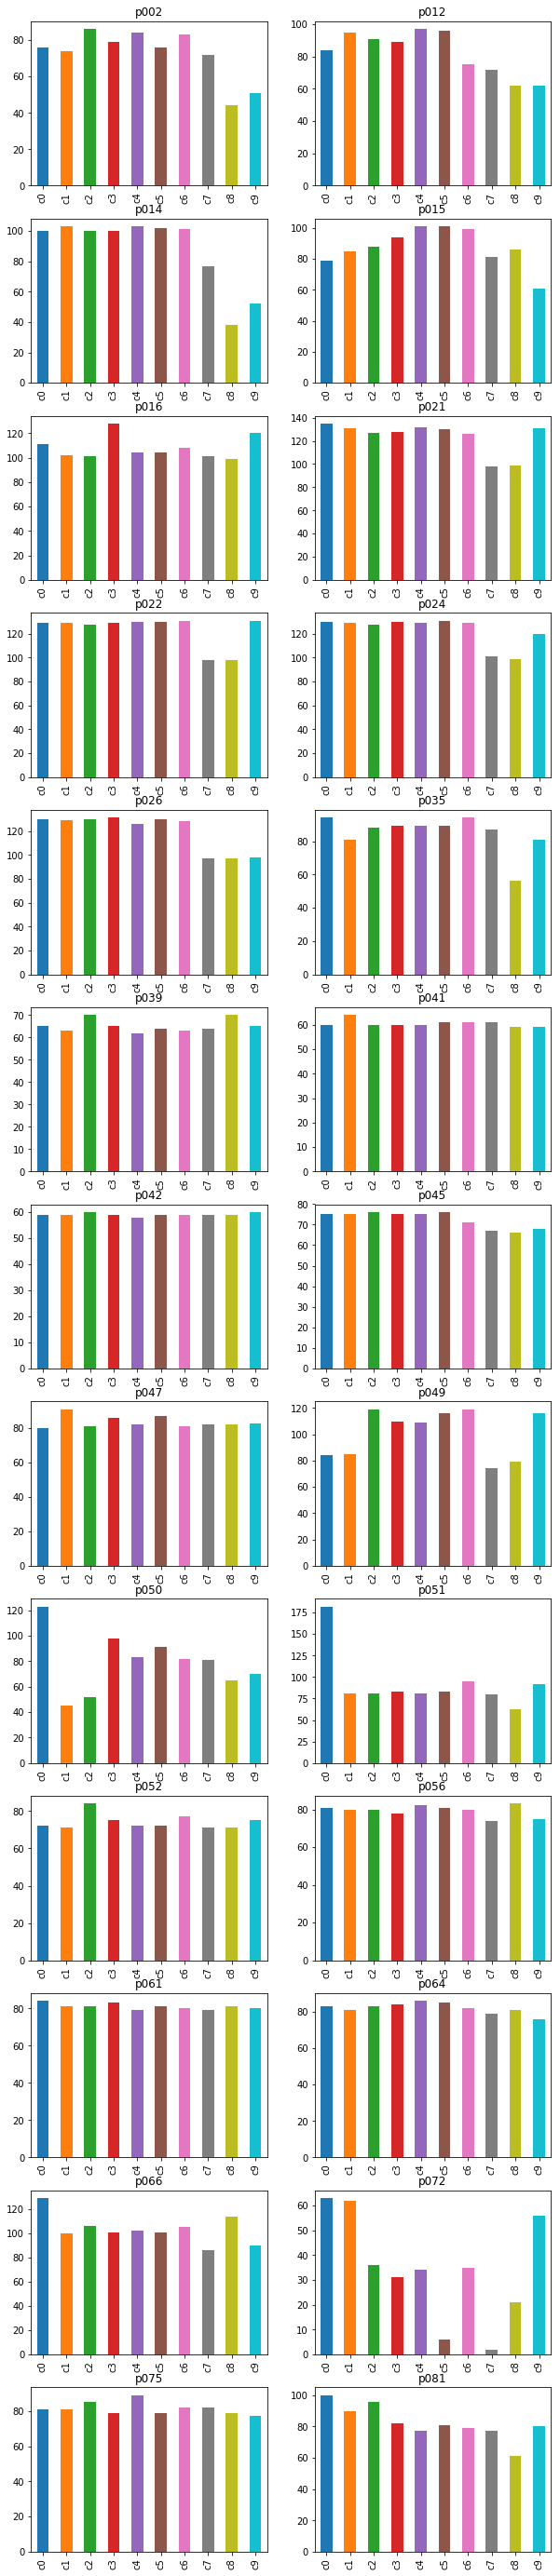

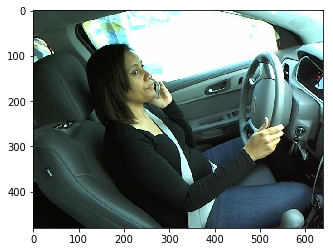

In [2]:
# 数据文件处理
# 将所有img放到一个文件夹中，便于driver_imgs_list进行索引
# # 使用data augmentation，加载driver_imgs_list_aug.csv
# csv = pd.read_csv('./driver_imgs_list_aug.csv')
# 不使用data augmentation，加载driver_imgs_list.csv，并添加路径前缀
csv = pd.read_csv('./driver_imgs_list.csv')
# csv['img'] = './imgs/train/' + csv['classname'] + '/' + csv['img']
print(csv.head())

# 统计训练集总数
raw_train_num = csv.shape[0]
print('原始训练集样本数为：'+ str(raw_train_num))
# 统计司机人数
subject_num = csv['subject'].nunique()
print('原始训练集司机人数为：'+str(subject_num))
subject_list = list(csv['subject'].unique())
# 统计行为类别
class_num = csv['classname'].nunique()
print('原始训练集行为类别数为：'+ str(class_num))
# 原始训练集按司机分布
plt.figure(1)
subject_hist = csv['subject'].value_counts().sort_index()
subject_hist.plot(kind='bar')
# 原始训练集按行为分布
plt.figure(2)
class_hist = csv['classname'].value_counts().sort_index()
class_hist.plot(kind='bar')
# 考察每个驾驶员的行为分类，判断按驾驶员划分验证集会不会类别不平衡
plt.figure(3,figsize=(10,50))
for i in range(subject_num):
    plt.subplot(subject_num/2,2, i+1)
    class_hist = csv[csv['subject']==subject_list[i]]['classname'].value_counts().sort_index()
    class_hist.plot(kind='bar')
    plt.title(subject_list[i])

# p051类别不均衡，正常驾驶的数据太多，丢弃部分
csv.drop(csv.query("subject == 'p051' and classname == 'c0'").sample(75,random_state=1).index).reset_index(drop=True)
# p072数据量较小，且类别十分不均衡，直接丢弃
csv = csv.drop(csv.query("subject == 'p072'").index).reset_index(drop=True)

# 随机可视化图像
import random
sample = csv.sample(random_state=100)
print(sample)
img = cv2.imread(sample.iloc[0,2])
print(img.shape)
img = img[:,:,::-1]
plt.figure(4)
plt.imshow(img)

In [3]:
# 拆分训练集、验证集，由于图像都是从视频中剪出，直接随机打乱不能构成独立同分布，验证集中的大部分图像都能从训练集中找到极为相似的
# 应该按驾驶员来划分，首先能够满足独立，其次驾驶员属性并不改变动作行为的样本分布
random.seed(1)
valid_subject = random.sample(subject_list,int(subject_num * 0.20)) # 大约选取20%作为验证集
print('作为验证集的驾驶员分类：')
# print(valid_subject)
valid_idx = csv['subject'].isin(valid_subject)
train = csv[~valid_idx]
valid = csv[valid_idx]
valid = valid[valid['img'].str.split('/').str[1] == 'imgs'] # valid不算random patch
print(len(train))
print(len(valid))

# shuffle
from sklearn.utils import shuffle  
train = shuffle(train, random_state=1)
# print(train)
small_train = train.sample(2000,random_state=1) # 小训练集，便于检验pipeline
# print(small_train)
valid = shuffle(valid, random_state=1)

# 拆分样本和标签
# 大训练集
train_label = train['classname']
train_label = pd.get_dummies(train_label).values # one-hot encode
train_sample = train.drop(['subject', 'classname'], axis=1).values
train_sample = [img[0] for img in train_sample]
# 小训练集
small_train_label = small_train['classname']
small_train_label = pd.get_dummies(small_train_label).values # one-hot encode
small_train_sample = small_train.drop(['subject', 'classname'], axis=1).values
small_train_sample = [img[0] for img in small_train_sample]
#验证集
valid_label = valid['classname']
valid_label = pd.get_dummies(valid_label).values # one-hot encode
valid_sample = valid.drop(['subject', 'classname'], axis=1).values
valid_sample = [img[0] for img in valid_sample]
# 测试集
import glob
test_sample = glob.glob('./imgs/test/*.jpg')
test_label_placeholder = np.zeros((len(test_sample), 10), dtype=np.uint8) # 无实际意义，占位符，便于iterator通用

# 总训练集
# dataset
total_train = csv
total_train = shuffle(total_train, random_state=1)
total_train_label = total_train['classname']
total_train_label = pd.get_dummies(total_train_label).values # one-hot encode
total_train_sample = total_train.drop(['subject', 'classname'], axis=1).values
total_train_sample = [img[0] for img in total_train_sample]


作为验证集的驾驶员分类：
17747
4331


In [50]:
# 构建dataset
tf.reset_default_graph()

# ImageNet训练集的mean
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_CHANNEL_MEANS = [_R_MEAN, _G_MEAN, _B_MEAN] # RGB mode

# 函数的功能时将filename对应的图片文件读进来，并缩放到统一的大小
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image = tf.image.decode_jpeg(image_string,3) # RGB mode
    image = tf.image.resize_images(image, [224, 224])
    means = tf.expand_dims(tf.expand_dims(_CHANNEL_MEANS, 0), 0)
    image -= means # zero center，针对VGG
#     image = image / 255. # 归一化,针对基准神经网络
    return filename, image, label


# 此时dataset中的一个元素是(filename, label)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sample, train_label))
print(train_dataset)
small_train_dataset = tf.data.Dataset.from_tensor_slices((small_train_sample, small_train_label))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_sample, valid_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sample, test_label_placeholder))

total_train_dataset = tf.data.Dataset.from_tensor_slices((total_train_sample, total_train_label))
# print(train_dataset)
# print(small_train_dataset)
# print(valid_dataset)
# print(test_dataset)



# shuffle
# 此时dataset中的一个元素是(filename, label)
train_dataset = train_dataset.shuffle(buffer_size=len(train))
small_train_dataset = small_train_dataset.shuffle(buffer_size=len(small_train))
total_train_dataset = total_train_dataset.shuffle(buffer_size=len(total_train))

# 此时dataset中的一个元素是(filename, image, label)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=12)
small_train_dataset = small_train_dataset.map(_parse_function, num_parallel_calls=12)
valid_dataset = valid_dataset.map(_parse_function, num_parallel_calls=12)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=12) 
total_train_dataset = total_train_dataset.map(_parse_function, num_parallel_calls=12)

# mini-batch
train_dataset = train_dataset.batch(64)
small_train_dataset = small_train_dataset.batch(64)
valid_dataset = valid_dataset.batch(64)
test_dataset = test_dataset.batch(64)
total_train_dataset = total_train_dataset.batch(64)

# 此时dataset中的一个元素是(filename_batch, image_batch, label_batch)
print(train_dataset)
print(small_train_dataset)
print(valid_dataset)
print(test_dataset)
print(total_train_dataset)

# prefetch
train_dataset = train_dataset.prefetch(1)
small_train_dataset = small_train_dataset.prefetch(1)
valid_dataset = valid_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)
total_train_dataset = total_train_dataset.prefetch(1)





# 构造iterator
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
train_iterator_op = iterator.make_initializer(train_dataset)
small_train_iterator_op = iterator.make_initializer(small_train_dataset)
valid_iterator_op = iterator.make_initializer(valid_dataset)
test_iterator_op = iterator.make_initializer(test_dataset)
total_train_iterator_op = iterator.make_initializer(total_train_dataset)



<TensorSliceDataset shapes: ((), (10,)), types: (tf.string, tf.uint8)>
<BatchDataset shapes: ((?,), (?, 224, 224, 3), (?, 10)), types: (tf.string, tf.float32, tf.uint8)>
<BatchDataset shapes: ((?,), (?, 224, 224, 3), (?, 10)), types: (tf.string, tf.float32, tf.uint8)>
<BatchDataset shapes: ((?,), (?, 224, 224, 3), (?, 10)), types: (tf.string, tf.float32, tf.uint8)>
<BatchDataset shapes: ((?,), (?, 224, 224, 3), (?, 10)), types: (tf.string, tf.float32, tf.uint8)>
<BatchDataset shapes: ((?,), (?, 224, 224, 3), (?, 10)), types: (tf.string, tf.float32, tf.uint8)>


In [47]:
# 构建基准神经网络

train_flag = tf.placeholder(tf.bool, shape=(), name="train_flag")

filename, x, y = iterator.get_next()

image_summary_op = tf.summary.image('input', x,10)

# conv 1
Conv1 = tf.layers.Conv2D(
        filters=64,
        kernel_size=3,
        strides=(3, 3),
        padding='valid',
        data_format='channels_last',
        dilation_rate=(1, 1),
        activation=None,
        use_bias=True,
        kernel_initializer=tf.keras.initializers.he_normal(seed=None),
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
        name='conv1'
        )
tf.summary.histogram('Conv1/weights', Conv1.trainable_weights)

# pooling 1
Pooling1 = tf.layers.MaxPooling2D(
        pool_size=2,
        strides=2,
        padding='valid',
        data_format='channels_last',
        name='pooling1'
    )

# conv 2
Conv2 = tf.layers.Conv2D(
        filters=128,
        kernel_size=3,
        strides=(3, 3),
        padding='valid',
        data_format='channels_last',
        dilation_rate=(1, 1),
        activation=None,
        use_bias=True,
        kernel_initializer=tf.keras.initializers.he_normal(seed=None),
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
        name='conv2'
        )
tf.summary.histogram('Conv2/weights', Conv2.trainable_weights)


# pooling 2
Pooling2 = tf.layers.MaxPooling2D(
        pool_size=2,
        strides=2,
        padding='valid',
        data_format='channels_last',
        name='pooling2'
    )


# flatten
Flatten1 = tf.layers.Flatten(name='flatten')

# dropout1
Dropout1 = tf.layers.Dropout(name='dropout1')

# dense 1
Dense1 = tf.layers.Dense(
        units=100,
        activation=tf.nn.relu,
        use_bias=True,
        kernel_initializer=tf.keras.initializers.he_normal(seed=None),
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
        name='dense1'
        )
tf.summary.histogram('Dense1/weights', Dense1.trainable_weights)



# dropout2
Dropout2 = tf.layers.Dropout(name='dropout2')

# output
Output = tf.layers.Dense(
        units=10,
        activation=None,
        use_bias=True,
        kernel_initializer=tf.keras.initializers.he_normal(seed=None),
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
        name='output'
        )
tf.summary.histogram('Output/weights', Output.trainable_weights)


# network pipeline
x = Conv1(x)
x = Pooling1(x)
# relu 1
x = tf.nn.relu(x, name='relu1')
x = Conv2(x)
x = Pooling2(x)
# relu 2
x = tf.nn.relu(x, name='relu2')
x = Flatten1(x)
x = Dropout1(x, training=train_flag)
x = Dense1(x)
x = Dropout2(x, training=train_flag)
y_hat = Output(x)
y_predict = tf.nn.softmax(y_hat)


# summary merged, loss and acc not included
merged = tf.summary.merge_all()

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
loss_placeholder = tf.placeholder(tf.float32,shape=(), name='loss')
loss_summary_op = tf.summary.scalar('cross_entropy', loss_placeholder)

# train op
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0001,
                beta1=0.9,
                beta2=0.999,
                epsilon=1e-08,
                use_locking=False,
                name='Adam'
            )
train_op = optimizer.minimize(loss, global_step)

# get accuracy
predict = tf.argmax(y_hat, 1)
equal = tf.equal(predict, tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(equal, tf.float32))
acc_placeholder = tf.placeholder(tf.float32,shape=(), name='acc')
acc_summary_op = tf.summary.scalar('accuracy', acc_placeholder)



# 初始化变量
init_op = tf.global_variables_initializer()

In [48]:
# 训练基准神经网络
import time
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(init_op)
   

    log_path = './log/baseline'
    if tf.gfile.Exists(log_path):
        tf.gfile.DeleteRecursively(log_path)
    tf.gfile.MakeDirs(log_path)
    train_writer = tf.summary.FileWriter(log_path+'/train', sess.graph)
    valid_writer = tf.summary.FileWriter(log_path+'/valid')

    
    EPOCHES = 15
    for epoch in range(EPOCHES):
        start_time = time.time()
        sess.run(train_iterator_op)
#     sess.run(small_train_iterator_op)

        # training for one epoch
        while True:
            try:
                sess.run(train_op, feed_dict={train_flag:True})
            except tf.errors.OutOfRangeError:
                break
        
        # summary weights
        step = sess.run(global_step)
        sess.run(train_iterator_op)
        merged_summary = sess.run(merged)
        train_writer.add_summary(merged_summary, step)  
        
        # For each epoch, calculate the loss and acc over entire train set
        sess.run(train_iterator_op)
        train_batch = 0
        total_loss = 0
        total_acc = 0
        while True:
            try:
                loss_value, acc_value = sess.run([loss, acc], feed_dict={train_flag:False})
                train_batch += 1
                total_loss += loss_value
                total_acc += acc_value
            except tf.errors.OutOfRangeError:
                break
        cross_entropy_value = total_loss / train_batch
        acc_value = total_acc / train_batch
        print("Epoch: {}, Step: {}, Loss: {:.4f}, acc: {:.4f}".format(epoch, step, cross_entropy_value, acc_value))
        sess.run(train_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
        loss_summary, acc_summary = sess.run([loss_summary_op, acc_summary_op], feed_dict={loss_placeholder: cross_entropy_value, acc_placeholder:acc_value})
        train_writer.add_summary(loss_summary, step)
        train_writer.add_summary(acc_summary, step)
        end_time = time.time()
        print("Epoch: {}, train time comsuption: {}".format(epoch, end_time-start_time))
        
          
        
        # for each epoch, summary the loss and acc over entire valid set
        start_time = time.time()
        sess.run(valid_iterator_op)
        valid_batch = 0
        total_loss = 0
        total_acc = 0
        image_summary = sess.run(image_summary_op)
        valid_writer.add_summary(image_summary, step)
        while True:
            try:
                loss_value, acc_value = sess.run([loss, acc], feed_dict={train_flag:False})
                valid_batch += 1
                total_loss += loss_value
                total_acc += acc_value
            except tf.errors.OutOfRangeError:
                break 
        cross_entropy_value = total_loss / valid_batch
        acc_value = total_acc / valid_batch
        print("Epoch: {}, Step: {}, valid Loss: {:.4f}, valid acc: {:.4f}".format(epoch, step, cross_entropy_value, acc_value))
        sess.run(valid_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
        loss_summary, acc_summary = sess.run([loss_summary_op, acc_summary_op], feed_dict={loss_placeholder: cross_entropy_value, acc_placeholder:acc_value})
        valid_writer.add_summary(loss_summary, step)
        valid_writer.add_summary(acc_summary, step)
        
        end_time = time.time()
        print("Epoch: {}, valid time comsuption: {}".format(epoch, end_time-start_time))
    
    
    sess.run(test_iterator_op)
    import os
    test_prediction = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
    while True:
        try:
            filename_value, prediction = sess.run([filename, y_predict], feed_dict={train_flag:False})
            filename_value = [os.path.split(name)[1].decode('utf8') for name in filename_value]            
            test_prediction = test_prediction.append(pd.DataFrame(np.concatenate((np.array(filename_value)[:,np.newaxis], prediction), axis=1),
                                               columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']))
        except tf.errors.OutOfRangeError:
            break
    test_prediction.to_csv('./test_results_baseline.csv', index = False)
    print("test result saved")

Epoch: 0, Step: 278, Loss: 2.0996, acc: 0.3757
Epoch: 0, train time comsuption: 18.268072366714478
Epoch: 0, Step: 278, valid Loss: 2.2141, valid acc: 0.1826
Epoch: 0, valid time comsuption: 2.4134128093719482
Epoch: 1, Step: 556, Loss: 1.3402, acc: 0.6990
Epoch: 1, train time comsuption: 17.85447907447815
Epoch: 1, Step: 556, valid Loss: 1.9304, valid acc: 0.3813
Epoch: 1, valid time comsuption: 2.28745698928833
Epoch: 2, Step: 834, Loss: 0.8268, acc: 0.8825
Epoch: 2, train time comsuption: 17.92482566833496
Epoch: 2, Step: 834, valid Loss: 1.8498, valid acc: 0.3859
Epoch: 2, valid time comsuption: 2.2797365188598633
Epoch: 3, Step: 1112, Loss: 0.5010, acc: 0.9273
Epoch: 3, train time comsuption: 17.808263540267944
Epoch: 3, Step: 1112, valid Loss: 1.8339, valid acc: 0.4165
Epoch: 3, valid time comsuption: 2.27204966545105
Epoch: 4, Step: 1390, Loss: 0.3417, acc: 0.9457
Epoch: 4, train time comsuption: 17.79073667526245
Epoch: 4, Step: 1390, valid Loss: 1.8639, valid acc: 0.4358
Epoch

In [51]:
# transfer learning
# fine-tune VGG

train_flag = tf.placeholder(tf.bool, shape=(), name="train_flag")

filename, x, y = iterator.get_next()

image_summary_op = tf.summary.image('input', x,10)

# vgg with fc8 modified
vgg = slim.nets.vgg
with slim.arg_scope(vgg.vgg_arg_scope(weight_decay=0.5)):
    y_hat, _ = vgg.vgg_16(x, is_training=train_flag, dropout_keep_prob =0.4, num_classes=10)

variables_to_restore = slim.get_variables_to_restore(exclude=["vgg_16/fc8"])
fc8_variables = tf.contrib.framework.get_variables('vgg_16/fc8')

y_predict = tf.nn.softmax(y_hat)


# summary merged, loss and acc not included
merged = tf.summary.merge_all()

# loss
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
cross_entropy_loss_placeholder = tf.placeholder(tf.float32,shape=(), name='cross_entropy_loss_placeholder')
cross_entropy_loss_summary_op = tf.summary.scalar('cross_entropy_loss', cross_entropy_loss_placeholder)
# L2 loss
regularization_loss = tf.add_n(tf.losses.get_regularization_losses())
regularization_loss_placeholder = tf.placeholder(tf.float32,shape=(), name='regularization_loss_placeholder')
regularization_loss_summary_op = tf.summary.scalar('regularization_loss', regularization_loss_placeholder)
# total loss
loss = cross_entropy_loss + regularization_loss
loss_placeholder = tf.placeholder(tf.float32,shape=(), name='total_loss_placeholder')
loss_summary_op = tf.summary.scalar('total_loss', loss_placeholder)

# train op
global_step = tf.Variable(0, name='global_step', trainable=False)
# global_step = tf.get_variable(name='global_step', initializer=tf.constant_initializer(0),shape=[], trainable=False)
optimizer = tf.train.AdamOptimizer(
                learning_rate=1e-5,
                name='Adam'
            )
# # only train fc8 layer
# train_op = optimizer.minimize(loss, var_list=fc8_variables, global_step=global_step)
# fine-tune all layers
train_op = optimizer.minimize(loss, global_step=global_step)



# get accuracy
predict = tf.argmax(y_hat, 1)
equal = tf.equal(predict, tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(equal, tf.float32))
acc_placeholder = tf.placeholder(tf.float32,shape=(), name='acc')
acc_summary_op = tf.summary.scalar('accuracy', acc_placeholder)

# 初始化，fc8_init
model_path = './vgg_16.ckpt'
init_fn = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_to_restore)
fc8_init = tf.variables_initializer(fc8_variables)

In [52]:
# fine-tune VGG
# train on train/valid split
import time
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    init_fn(sess) # init_fn is a function
    sess.run(fc8_init)
    report_uninitialized_variables = sess.run(tf.report_uninitialized_variables())
    report_uninitialized_variables = [name.decode('UTF-8') for name in report_uninitialized_variables]
    uninitialized_variables = []
    for v in tf.global_variables():
        if v.name.split(':')[0] in report_uninitialized_variables:
            uninitialized_variables.append(v)
    sess.run(tf.variables_initializer(uninitialized_variables))


    
    log_path = './log/vgg_fine-tuning_lr_1e-5_kp_0.4_L2_0.5'
    if tf.gfile.Exists(log_path):
        tf.gfile.DeleteRecursively(log_path)
    tf.gfile.MakeDirs(log_path)
    train_writer = tf.summary.FileWriter(log_path+'/train', sess.graph)
    valid_writer = tf.summary.FileWriter(log_path+'/valid')

    
    EPOCHES = 10
    for epoch in range(EPOCHES):
        start_time = time.time()
        sess.run(train_iterator_op)
#     sess.run(small_train_iterator_op)

    
        # training for one epoch
        while True:
            try:
                sess.run(train_op, feed_dict={train_flag:True})
            except tf.errors.OutOfRangeError:
                break
        
        # summary weights
        step = sess.run(global_step)
        sess.run(train_iterator_op)
        merged_summary = sess.run(merged)
        train_writer.add_summary(merged_summary, step)  
        
        # For each epoch, calculate the loss and acc over entire train set
        sess.run(train_iterator_op)
#     sess.run(small_train_iterator_op)
        train_batch = 0
        total_cross_entropy_loss = 0
        total_regularization_loss = 0
        total_loss = 0
        total_acc = 0
        while True:
            try:
                loss_value, cross_entropy_loss_value, regularization_loss_value, acc_value = sess.run([loss, cross_entropy_loss, regularization_loss, acc], feed_dict={train_flag:False})
                train_batch += 1
                total_loss += loss_value
                total_cross_entropy_loss += cross_entropy_loss_value
                total_regularization_loss += regularization_loss_value
                total_acc += acc_value
            except tf.errors.OutOfRangeError:
                break
        loss_value = total_loss / train_batch
        cross_entropy_loss_value = total_cross_entropy_loss / train_batch
        regularization_loss_value = total_regularization_loss / train_batch
        acc_value = total_acc / train_batch
        print("Epoch: {}, Step: {}, Loss: {:.4f}, Cross Entropy Loss: {:.4f}, Regularization Loss: {:.4f}, acc: {:.4f}".format(epoch, step, loss_value, cross_entropy_loss_value,regularization_loss_value , acc_value))
        sess.run(train_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
        loss_summary, cross_entropy_loss_summary, regularization_loss_loss_summary, acc_summary = sess.run([loss_summary_op, cross_entropy_loss_summary_op, regularization_loss_summary_op, acc_summary_op], 
                                             feed_dict={loss_placeholder: loss_value,
                                                        cross_entropy_loss_placeholder: cross_entropy_loss_value,
                                                        regularization_loss_placeholder: regularization_loss_value,
                                                        acc_placeholder:acc_value})
        train_writer.add_summary(loss_summary, step)
        train_writer.add_summary(cross_entropy_loss_summary, step)
        train_writer.add_summary(regularization_loss_loss_summary, step)
        train_writer.add_summary(acc_summary, step)
        end_time = time.time()
        print("Epoch: {}, train time comsuption: {}".format(epoch, end_time-start_time))
                
        # for each epoch, summary the loss and acc over entire valid set
        start_time = time.time()
        sess.run(valid_iterator_op)
        valid_batch = 0
        total_cross_entropy_loss = 0
        total_acc = 0
        image_summary = sess.run(image_summary_op)
        valid_writer.add_summary(image_summary, step)
        while True:
            try:
                cross_entropy_loss_value, acc_value = sess.run([cross_entropy_loss, acc], feed_dict={train_flag:False})
                valid_batch += 1
                total_cross_entropy_loss += cross_entropy_loss_value
                total_acc += acc_value
            except tf.errors.OutOfRangeError:
                break 
        cross_entropy_loss_value = total_cross_entropy_loss / valid_batch
        acc_value = total_acc / valid_batch
        print("Epoch: {}, Step: {}, valid Loss: {:.4f}, valid acc: {:.4f}".format(epoch, step, cross_entropy_loss_value, acc_value))
        sess.run(valid_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
        cross_entropy_loss_summary, acc_summary = sess.run([cross_entropy_loss_summary_op, acc_summary_op], 
                                                           feed_dict={cross_entropy_loss_placeholder: cross_entropy_loss_value, 
                                                                      acc_placeholder:acc_value})
        valid_writer.add_summary(cross_entropy_loss_summary, step)
        valid_writer.add_summary(acc_summary, step)
        
        end_time = time.time()
        print("Epoch: {}, valid time comsuption: {}".format(epoch, end_time-start_time))

INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt
Epoch: 0, Step: 278, Loss: 375.3652, Cross Entropy Loss: 0.0531, Regularization Loss: 375.3120, acc: 0.9871
Epoch: 0, train time comsuption: 256.79406356811523
Epoch: 0, Step: 278, valid Loss: 0.6301, valid acc: 0.7998
Epoch: 0, valid time comsuption: 14.196063041687012
Epoch: 1, Step: 556, Loss: 262.5824, Cross Entropy Loss: 0.0223, Regularization Loss: 262.5600, acc: 0.9943
Epoch: 1, train time comsuption: 256.30836248397827
Epoch: 1, Step: 556, valid Loss: 0.6444, valid acc: 0.7838
Epoch: 1, valid time comsuption: 13.94302225112915
Epoch: 2, Step: 834, Loss: 195.2301, Cross Entropy Loss: 0.0705, Regularization Loss: 195.1595, acc: 0.9776
Epoch: 2, train time comsuption: 256.66993832588196
Epoch: 2, Step: 834, valid Loss: 0.5253, valid acc: 0.8430
Epoch: 2, valid time comsuption: 13.913652896881104
Epoch: 3, Step: 1112, Loss: 151.8160, Cross Entropy Loss: 0.0514, Regularization Loss: 151.7646, acc: 0.9893
Epoch: 3, train time co

KeyboardInterrupt: 

In [ ]:
# search scale of L2 regularization

import time
import glob


# 加载driver_imgs_list.csv
csv = pd.read_csv('./driver_imgs_list.csv')

# p051类别不均衡，正常驾驶的数据太多，丢弃部分
csv.drop(csv.query("subject == 'p051' and classname == 'c0'").sample(75,random_state=1).index).reset_index(drop=True)
# p072数据量较小，且类别十分不均衡，直接丢弃
csv = csv.drop(csv.query("subject == 'p072'").index).reset_index(drop=True)

subject_list = list(csv['subject'].unique())
subject_num = csv['subject'].nunique()
random.seed(1)
random.shuffle(subject_list)
valid_subject = random.sample(subject_list,int(subject_num * 0.20)) # 大约选取20%作为验证集
print('作为验证集的驾驶员分类：')
# print(valid_subject)
valid_idx = csv['subject'].isin(valid_subject)
train = csv[~valid_idx]
valid = csv[valid_idx]
valid = valid[valid['img'].str.split('/').str[1] == 'imgs'] # valid不算random patch
print('训练集大小：' + str(len(train)))
print('验证集大小：' + str(len(valid)))
# shuffle
from sklearn.utils import shuffle  
train = shuffle(train, random_state=1)
# print(train)
small_train = train.sample(200,random_state=1) # 小训练集，便于检验pipeline
# print(small_train)
valid = shuffle(valid, random_state=1)

# 拆分样本和标签
# 大训练集
train_label = train['classname']
train_label = pd.get_dummies(train_label).values # one-hot encode
train_sample = train.drop(['subject', 'classname'], axis=1).values
train_sample = [img[0] for img in train_sample]
# print(train_sample)
# 小训练集
small_train_label = small_train['classname']
small_train_label = pd.get_dummies(small_train_label).values # one-hot encode
small_train_sample = small_train.drop(['subject', 'classname'], axis=1).values
small_train_sample = [img[0] for img in small_train_sample]
#验证集
valid_label = valid['classname']
valid_label = pd.get_dummies(valid_label).values # one-hot encode
valid_sample = valid.drop(['subject', 'classname'], axis=1).values
valid_sample = [img[0] for img in valid_sample]
# 测试集
test_sample = glob.glob('./imgs/test/*.jpg')
test_label_placeholder = np.zeros((len(test_sample), 10), dtype=np.uint8) # 无实际意义，占位符，便于iterator通用


lambd_list = [0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5] 
lambd_val_loss = {}
for lambd in lambd_list:
    print('*'*60)
    print(' '*25 + 'Lambda: '+str(lambd))
    print('*'*60)
    
    tf.reset_default_graph()

    # ImageNet训练集的mean
    _R_MEAN = 123.68
    _G_MEAN = 116.78
    _B_MEAN = 103.94
    _CHANNEL_MEANS = [_R_MEAN, _G_MEAN, _B_MEAN] # RGB mode

    # 函数的功能时将filename对应的图片文件读进来，并缩放到统一的大小
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_jpeg(image_string,3) # RGB mode
        image = tf.image.resize_images(image, [224, 224])
        means = tf.expand_dims(tf.expand_dims(_CHANNEL_MEANS, 0), 0)
        image -= means # zero center
    #     image = image / 255. # 归一化
        return filename, image, label

    train_dataset = tf.data.Dataset.from_tensor_slices((train_sample, train_label))
#     print(train_dataset)
    small_train_dataset = tf.data.Dataset.from_tensor_slices((small_train_sample, small_train_label))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_sample, valid_label))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_sample, test_label_placeholder))
    
    # shuffle
    # 此时dataset中的一个元素是(filename, label)
    train_dataset = train_dataset.shuffle(buffer_size=len(train))
    small_train_dataset = small_train_dataset.shuffle(buffer_size=len(small_train))

    # map
    train_dataset = train_dataset.map(_parse_function, num_parallel_calls=12)
    small_train_dataset = small_train_dataset.map(_parse_function, num_parallel_calls=12)
    valid_dataset = valid_dataset.map(_parse_function, num_parallel_calls=12)
    test_dataset = test_dataset.map(_parse_function, num_parallel_calls=12)

    # batch
    train_dataset = train_dataset.batch(64)
    small_train_dataset = small_train_dataset.batch(64)
    valid_dataset = valid_dataset.batch(64)
    test_dataset = test_dataset.batch(64)

    # prefetch
    train_dataset = train_dataset.prefetch(1)
    small_train_dataset = small_train_dataset.prefetch(1)
    valid_dataset = valid_dataset.prefetch(1)
    test_dataset = test_dataset.prefetch(1)


    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                                   train_dataset.output_shapes)
    train_iterator_op = iterator.make_initializer(train_dataset)
    small_train_iterator_op = iterator.make_initializer(small_train_dataset)
    valid_iterator_op = iterator.make_initializer(valid_dataset)
    test_iterator_op = iterator.make_initializer(test_dataset)


    # vgg-16 
    # fine-tune
    train_flag = tf.placeholder(tf.bool, shape=(), name="train_flag")
    filename, x, y = iterator.get_next()
    # vgg with fc8 modified
    vgg = slim.nets.vgg
    with slim.arg_scope(vgg.vgg_arg_scope(weight_decay=lambd)):
        y_hat, _ = vgg.vgg_16(x, is_training=train_flag, dropout_keep_prob =0.3, num_classes=10)

    variables_to_restore = slim.get_variables_to_restore(exclude=["vgg_16/fc8"])
    fc8_variables = tf.contrib.framework.get_variables('vgg_16/fc8')


    
    y_predict = tf.nn.softmax(y_hat)

    # loss
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
    cross_entropy_loss_placeholder = tf.placeholder(tf.float32,shape=(), name='cross_entropy_loss_placeholder')
    cross_entropy_loss_summary_op = tf.summary.scalar('cross_entropy_loss', cross_entropy_loss_placeholder)
    # L2 loss
    regularization_loss = tf.add_n(tf.losses.get_regularization_losses())
    regularization_loss_placeholder = tf.placeholder(tf.float32,shape=(), name='regularization_loss_placeholder')
    regularization_loss_summary_op = tf.summary.scalar('regularization_loss', regularization_loss_placeholder)
    # total loss
    loss = cross_entropy_loss + regularization_loss
    loss_placeholder = tf.placeholder(tf.float32,shape=(), name='total_loss_placeholder')
    loss_summary_op = tf.summary.scalar('total_loss', loss_placeholder)

    # train op
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # global_step = tf.get_variable(name='global_step', initializer=tf.constant_initializer(0),shape=[], trainable=False)
    optimizer = tf.train.AdamOptimizer(
                    learning_rate=1e-5,
                    name='Adam'
                )
    # # only train fc8 layer
    # train_op = optimizer.minimize(loss, var_list=fc8_variables, global_step=global_step)
    # fine-tune all layers
    train_op = optimizer.minimize(loss, global_step=global_step)

    # get accuracy
    predict = tf.argmax(y_hat, 1)
    equal = tf.equal(predict, tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(equal, tf.float32))
    acc_placeholder = tf.placeholder(tf.float32,shape=(), name='acc')
    acc_summary_op = tf.summary.scalar('accuracy', acc_placeholder)

    # 初始化，fc8_init
    model_path = './vgg_16.ckpt'
    init_fn = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_to_restore)
    fc8_init = tf.variables_initializer(fc8_variables)

    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        init_fn(sess) # init_fn is a function
        sess.run(fc8_init)
        report_uninitialized_variables = sess.run(tf.report_uninitialized_variables())
        report_uninitialized_variables = [name.decode('UTF-8') for name in report_uninitialized_variables]
        uninitialized_variables = []
        for v in tf.global_variables():
            if v.name.split(':')[0] in report_uninitialized_variables:
                uninitialized_variables.append(v)
        sess.run(tf.variables_initializer(uninitialized_variables))

        save_str = 'vgg_fine-tuning_lr_1e-5_kp_0.3_L2_'+str(lambd)
        log_path = './log/' + save_str
        if tf.gfile.Exists(log_path):
            tf.gfile.DeleteRecursively(log_path)
        tf.gfile.MakeDirs(log_path)
        train_writer = tf.summary.FileWriter(log_path+'/train', sess.graph)
        valid_writer = tf.summary.FileWriter(log_path+'/valid')

        # early stopping initialization
        min_val_loss = 100
        patience_count = 0
        PATIENCE = 3
        min_val_epoch = 0
        
        EPOCHES = 5
        for epoch in range(EPOCHES):
            start_time = time.time()
            sess.run(train_iterator_op)
#             sess.run(small_train_iterator_op)

            # training for one epoch
            while True:
                try:
                    sess.run(train_op, feed_dict={train_flag:True})
                except tf.errors.OutOfRangeError:
                    break

            # summary weights
            step = sess.run(global_step)

            # For each epoch, calculate the loss and acc over entire train set
            sess.run(train_iterator_op)
#             sess.run(small_train_iterator_op)
            train_batch = 0
            total_cross_entropy_loss = 0
            total_regularization_loss = 0
            total_loss = 0
            total_acc = 0
            while True:
                try:
                    loss_value, cross_entropy_loss_value, regularization_loss_value, acc_value = sess.run([loss, cross_entropy_loss, regularization_loss, acc], feed_dict={train_flag:False})
                    train_batch += 1
                    total_loss += loss_value
                    total_cross_entropy_loss += cross_entropy_loss_value
                    total_regularization_loss += regularization_loss_value
                    total_acc += acc_value
                except tf.errors.OutOfRangeError:
                    break
            loss_value = total_loss / train_batch
            cross_entropy_loss_value = total_cross_entropy_loss / train_batch
            regularization_loss_value = total_regularization_loss / train_batch
            acc_value = total_acc / train_batch
            print("Epoch: {}, Step: {}, Loss: {:.4f}, Cross Entropy Loss: {:.4f}, Regularization Loss: {:.4f}, acc: {:.4f}".format(epoch, step, loss_value, cross_entropy_loss_value,regularization_loss_value , acc_value))
            sess.run(train_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
            loss_summary, cross_entropy_loss_summary, regularization_loss_loss_summary, acc_summary = sess.run([loss_summary_op, cross_entropy_loss_summary_op, regularization_loss_summary_op, acc_summary_op], 
                                                 feed_dict={loss_placeholder: loss_value,
                                                            cross_entropy_loss_placeholder: cross_entropy_loss_value,
                                                            regularization_loss_placeholder: regularization_loss_value,
                                                            acc_placeholder:acc_value})
            train_writer.add_summary(loss_summary, step)
            train_writer.add_summary(cross_entropy_loss_summary, step)
            train_writer.add_summary(regularization_loss_loss_summary, step)
            train_writer.add_summary(acc_summary, step)
            end_time = time.time()
            print("Epoch: {}, train time comsuption: {}".format(epoch, end_time-start_time))

            # for each epoch, summary the loss and acc over entire valid set
            start_time = time.time()
            sess.run(valid_iterator_op)
            valid_batch = 0
            total_cross_entropy_loss = 0
            total_acc = 0
            while True:
                try:
                    cross_entropy_loss_value, acc_value = sess.run([cross_entropy_loss, acc], feed_dict={train_flag:False})
                    valid_batch += 1
                    total_cross_entropy_loss += cross_entropy_loss_value
                    total_acc += acc_value
                except tf.errors.OutOfRangeError:
                    break 
            cross_entropy_loss_value = total_cross_entropy_loss / valid_batch
            acc_value = total_acc / valid_batch
            print("Epoch: {}, Step: {}, valid Loss: {:.4f}, valid acc: {:.4f}".format(epoch, step, cross_entropy_loss_value, acc_value))
            sess.run(valid_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
            cross_entropy_loss_summary, acc_summary = sess.run([cross_entropy_loss_summary_op, acc_summary_op], 
                                                           feed_dict={cross_entropy_loss_placeholder: cross_entropy_loss_value, 
                                                                      acc_placeholder:acc_value})
            valid_writer.add_summary(cross_entropy_loss_summary, step)
            valid_writer.add_summary(acc_summary, step)

            end_time = time.time()
            print("Epoch: {}, valid time comsuption: {:.2f}".format(epoch, end_time-start_time))

            # early stopping
            # log best valid loss and save the model
            if cross_entropy_loss_value < min_val_loss:
                min_val_loss = cross_entropy_loss_value
                patience_count = 0
                lambd_val_loss[lambd] = min_val_loss
            else:
                patience_count += 1
            if patience_count > PATIENCE:
                print("Early stopping")
                break
print(lambd_val_loss)          
best_lambd = min(lambd_val_loss, key=lambd_val_loss.get) 




作为验证集的驾驶员分类：
训练集大小：17837
验证集大小：4241
************************************************************
                         Lambda: 0.005
************************************************************
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt
Epoch: 0, Step: 279, Loss: 5.4519, Cross Entropy Loss: 0.0571, Regularization Loss: 5.3948, acc: 0.9851
Epoch: 0, train time comsuption: 257.70642352104187
Epoch: 0, Step: 279, valid Loss: 0.6358, valid acc: 0.7748
Epoch: 0, valid time comsuption: 14.24
Epoch: 1, Step: 558, Loss: 5.2541, Cross Entropy Loss: 0.0214, Regularization Loss: 5.2327, acc: 0.9945
Epoch: 1, train time comsuption: 251.54651641845703
Epoch: 1, Step: 558, valid Loss: 0.6915, valid acc: 0.7719
Epoch: 1, valid time comsuption: 13.74
Epoch: 2, Step: 837, Loss: 5.1114, Cross Entrop

In [2]:
# train, valid
# 5-folds CV

import time
import glob
import os


# 加载driver_imgs_list_aug.csv
csv = pd.read_csv('./driver_imgs_list.csv')

# p051类别不均衡，正常驾驶的数据太多，丢弃部分
csv.drop(csv.query("subject == 'p051' and classname == 'c0'").sample(75,random_state=1).index).reset_index(drop=True)
# p072数据量较小，且类别十分不均衡，直接丢弃
csv = csv.drop(csv.query("subject == 'p072'").index).reset_index(drop=True)

subject_list = list(csv['subject'].unique())
random.seed(1)
random.shuffle(subject_list)

for fold in range(1,6):
    print('*'*60)
    print(' '*25 + 'Fold: '+str(fold))
    print('*'*60)
    valid_subject = subject_list[(fold - 1) * 5 : fold * 5]
    print('作为验证集的驾驶员分类：')
    print(valid_subject)
    valid_idx = csv['subject'].isin(valid_subject)
    train = csv[~valid_idx]
    valid = csv[valid_idx]
    valid = valid[valid['img'].str.split('/').str[1] == 'imgs'] # valid不算augmentation
    print('训练集大小：' + str(len(train)))
    print('验证集大小：' + str(len(valid)))

    # shuffle
    from sklearn.utils import shuffle  
    train = shuffle(train, random_state=1)
    # print(train)
    small_train = train.sample(200,random_state=1) # 小训练集，便于检验pipeline
    # print(small_train)
    valid = shuffle(valid, random_state=1)

    # 拆分样本和标签
    # 大训练集
    train_label = train['classname']
    train_label = pd.get_dummies(train_label).values # one-hot encode
    train_sample = train.drop(['subject', 'classname'], axis=1).values
    train_sample = [img[0] for img in train_sample]
    # print(train_sample)
    # 小训练集
    small_train_label = small_train['classname']
    small_train_label = pd.get_dummies(small_train_label).values # one-hot encode
    small_train_sample = small_train.drop(['subject', 'classname'], axis=1).values
    small_train_sample = [img[0] for img in small_train_sample]
    #验证集
    valid_label = valid['classname']
    valid_label = pd.get_dummies(valid_label).values # one-hot encode
    valid_sample = valid.drop(['subject', 'classname'], axis=1).values
    valid_sample = [img[0] for img in valid_sample]
    # 测试集
    test_sample = glob.glob('./imgs/test/*.jpg')
    test_label_placeholder = np.zeros((len(test_sample), 10), dtype=np.uint8) # 无实际意义，占位符，便于iterator通用

    tf.reset_default_graph()

    # ImageNet训练集的mean
    _R_MEAN = 123.68
    _G_MEAN = 116.78
    _B_MEAN = 103.94
    _CHANNEL_MEANS = [_R_MEAN, _G_MEAN, _B_MEAN] # RGB mode

    # 函数的功能时将filename对应的图片文件读进来，并缩放到统一的大小
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_jpeg(image_string,3) # RGB mode
        image = tf.image.resize_images(image, [224, 224])
        means = tf.expand_dims(tf.expand_dims(_CHANNEL_MEANS, 0), 0)
        image -= means # zero center
    #     image = image / 255. # 归一化
        return filename, image, label

    train_dataset = tf.data.Dataset.from_tensor_slices((train_sample, train_label))
#     print(train_dataset)
    small_train_dataset = tf.data.Dataset.from_tensor_slices((small_train_sample, small_train_label))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_sample, valid_label))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_sample, test_label_placeholder))
    
    # shuffle
    # 此时dataset中的一个元素是(filename, label)
    train_dataset = train_dataset.shuffle(buffer_size=len(train))
    small_train_dataset = small_train_dataset.shuffle(buffer_size=len(small_train))

    # map
    train_dataset = train_dataset.map(_parse_function, num_parallel_calls=12)
    small_train_dataset = small_train_dataset.map(_parse_function, num_parallel_calls=12)
    valid_dataset = valid_dataset.map(_parse_function, num_parallel_calls=12)
    test_dataset = test_dataset.map(_parse_function, num_parallel_calls=12)

    # batch
    train_dataset = train_dataset.batch(64)
    small_train_dataset = small_train_dataset.batch(64)
    valid_dataset = valid_dataset.batch(64)
    test_dataset = test_dataset.batch(64)

    # prefetch
    train_dataset = train_dataset.prefetch(1)
    small_train_dataset = small_train_dataset.prefetch(1)
    valid_dataset = valid_dataset.prefetch(1)
    test_dataset = test_dataset.prefetch(1)


    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                                   train_dataset.output_shapes)
    train_iterator_op = iterator.make_initializer(train_dataset)
    small_train_iterator_op = iterator.make_initializer(small_train_dataset)
    valid_iterator_op = iterator.make_initializer(valid_dataset)
    test_iterator_op = iterator.make_initializer(test_dataset)


    # vgg-16 
    # fine-tune
    train_flag = tf.placeholder(tf.bool, shape=(), name="train_flag")
    filename, x, y = iterator.get_next()
    # vgg with fc8 modified
    vgg = slim.nets.vgg
    with slim.arg_scope(vgg.vgg_arg_scope(weight_decay=0.3)):
        y_hat, _ = vgg.vgg_16(x, is_training=train_flag, dropout_keep_prob =0.3, num_classes=10)

    variables_to_restore = slim.get_variables_to_restore(exclude=["vgg_16/fc8"])
    fc8_variables = tf.contrib.framework.get_variables('vgg_16/fc8')
    variables_to_restore_test = slim.get_variables_to_restore()


    
    y_predict = tf.nn.softmax(y_hat)

    # loss
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
    cross_entropy_loss_placeholder = tf.placeholder(tf.float32,shape=(), name='cross_entropy_loss_placeholder')
    cross_entropy_loss_summary_op = tf.summary.scalar('cross_entropy_loss', cross_entropy_loss_placeholder)
    # L2 loss
    regularization_loss = tf.add_n(tf.losses.get_regularization_losses())
    regularization_loss_placeholder = tf.placeholder(tf.float32,shape=(), name='regularization_loss_placeholder')
    regularization_loss_summary_op = tf.summary.scalar('regularization_loss', regularization_loss_placeholder)
    # total loss
    loss = cross_entropy_loss + regularization_loss
    loss_placeholder = tf.placeholder(tf.float32,shape=(), name='total_loss_placeholder')
    loss_summary_op = tf.summary.scalar('total_loss', loss_placeholder)

    # train op
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # global_step = tf.get_variable(name='global_step', initializer=tf.constant_initializer(0),shape=[], trainable=False)
    optimizer = tf.train.AdamOptimizer(
                    learning_rate=1e-5,
                    name='Adam'
                )
    # # only train fc8 layer
    # train_op = optimizer.minimize(loss, var_list=fc8_variables, global_step=global_step)
    # fine-tune all layers
    train_op = optimizer.minimize(loss, global_step=global_step)

    # get accuracy
    predict = tf.argmax(y_hat, 1)
    equal = tf.equal(predict, tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(equal, tf.float32))
    acc_placeholder = tf.placeholder(tf.float32,shape=(), name='acc')
    acc_summary_op = tf.summary.scalar('accuracy', acc_placeholder)

    # 初始化，fc8_init
    model_path = './vgg_16.ckpt'
    init_fn = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_to_restore)
    fc8_init = tf.variables_initializer(fc8_variables)

    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        init_fn(sess) # init_fn is a function
        sess.run(fc8_init)
        report_uninitialized_variables = sess.run(tf.report_uninitialized_variables())
        report_uninitialized_variables = [name.decode('UTF-8') for name in report_uninitialized_variables]
        uninitialized_variables = []
        for v in tf.global_variables():
            if v.name.split(':')[0] in report_uninitialized_variables:
                uninitialized_variables.append(v)
        sess.run(tf.variables_initializer(uninitialized_variables))

        save_str = 'vgg_fine-tuning_lr_1e-5_kp_0.3_L2_0.3_fold_'+str(fold)
        log_path = './log/' + save_str
        if tf.gfile.Exists(log_path):
            tf.gfile.DeleteRecursively(log_path)
        tf.gfile.MakeDirs(log_path)
        train_writer = tf.summary.FileWriter(log_path+'/train', sess.graph)
        valid_writer = tf.summary.FileWriter(log_path+'/valid')

        # early stopping initialization
        min_val_loss = 100
        patience_count = 0
        PATIENCE = 2
        min_val_epoch = 0
        
        EPOCHES = 10
        for epoch in range(EPOCHES):
            start_time = time.time()
            sess.run(train_iterator_op)
#             sess.run(small_train_iterator_op)

            # training for one epoch
            while True:
                try:
                    sess.run(train_op, feed_dict={train_flag:True})
                except tf.errors.OutOfRangeError:
                    break

            # summary weights
            step = sess.run(global_step)

            # For each epoch, calculate the loss and acc over entire train set
            sess.run(train_iterator_op)
#             sess.run(small_train_iterator_op)
            train_batch = 0
            total_cross_entropy_loss = 0
            total_regularization_loss = 0
            total_loss = 0
            total_acc = 0
            while True:
                try:
                    loss_value, cross_entropy_loss_value, regularization_loss_value, acc_value = sess.run([loss, cross_entropy_loss, regularization_loss, acc], feed_dict={train_flag:False})
                    train_batch += 1
                    total_loss += loss_value
                    total_cross_entropy_loss += cross_entropy_loss_value
                    total_regularization_loss += regularization_loss_value
                    total_acc += acc_value
                except tf.errors.OutOfRangeError:
                    break
            loss_value = total_loss / train_batch
            cross_entropy_loss_value = total_cross_entropy_loss / train_batch
            regularization_loss_value = total_regularization_loss / train_batch
            acc_value = total_acc / train_batch
            print("Epoch: {}, Step: {}, Loss: {:.4f}, Cross Entropy Loss: {:.4f}, Regularization Loss: {:.4f}, acc: {:.4f}".format(epoch, step, loss_value, cross_entropy_loss_value,regularization_loss_value , acc_value))
            sess.run(train_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
            loss_summary, cross_entropy_loss_summary, regularization_loss_loss_summary, acc_summary = sess.run([loss_summary_op, cross_entropy_loss_summary_op, regularization_loss_summary_op, acc_summary_op], 
                                                 feed_dict={loss_placeholder: loss_value,
                                                            cross_entropy_loss_placeholder: cross_entropy_loss_value,
                                                            regularization_loss_placeholder: regularization_loss_value,
                                                            acc_placeholder:acc_value})
            train_writer.add_summary(loss_summary, step)
            train_writer.add_summary(cross_entropy_loss_summary, step)
            train_writer.add_summary(regularization_loss_loss_summary, step)
            train_writer.add_summary(acc_summary, step)
            end_time = time.time()
            print("Epoch: {}, train time comsuption: {}".format(epoch, end_time-start_time))

            # for each epoch, summary the loss and acc over entire valid set
            start_time = time.time()
            sess.run(valid_iterator_op)
            valid_batch = 0
            total_cross_entropy_loss = 0
            total_acc = 0
            while True:
                try:
                    cross_entropy_loss_value, acc_value = sess.run([cross_entropy_loss, acc], feed_dict={train_flag:False})
                    valid_batch += 1
                    total_cross_entropy_loss += cross_entropy_loss_value
                    total_acc += acc_value
                except tf.errors.OutOfRangeError:
                    break 
            cross_entropy_loss_value = total_cross_entropy_loss / valid_batch
            acc_value = total_acc / valid_batch
            print("Epoch: {}, Step: {}, valid Loss: {:.4f}, valid acc: {:.4f}".format(epoch, step, cross_entropy_loss_value, acc_value))
            sess.run(valid_iterator_op) # actually no use, but avoid the tf.errors.OutOfRangeError when running the next line
            cross_entropy_loss_summary, acc_summary = sess.run([cross_entropy_loss_summary_op, acc_summary_op], 
                                                           feed_dict={cross_entropy_loss_placeholder: cross_entropy_loss_value, 
                                                                      acc_placeholder:acc_value})
            valid_writer.add_summary(cross_entropy_loss_summary, step)
            valid_writer.add_summary(acc_summary, step)

            end_time = time.time()
            print("Epoch: {}, valid time comsuption: {:.2f}".format(epoch, end_time-start_time))

            # early stopping
            # log best valid loss and save the model
            if cross_entropy_loss_value < min_val_loss:
                min_val_loss = cross_entropy_loss_value
                patience_count = 0
                min_val_epoch = epoch
                saver = tf.train.Saver()
                saver.save(sess, './model/' + save_str + '.ckpt')
            else:
                patience_count += 1
            if patience_count > PATIENCE:
                print("Early stopping: stopping epoch {}, current epoch {}".format(min_val_epoch, epoch))
                break
                
                
        model_path = './model/' + save_str + '.ckpt'
        init_fn_test = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_to_restore_test)

        init_fn_test(sess) # init_fn is a function

        sess.run(test_iterator_op)
        test_prediction = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
        while True:
            try:
                filename_value, prediction = sess.run([filename, y_predict], feed_dict={train_flag:False})
                filename_value = [os.path.split(name)[1].decode('utf8') for name in filename_value]            
                test_prediction = test_prediction.append(pd.DataFrame(np.concatenate((np.array(filename_value)[:,np.newaxis], prediction), axis=1),
                                                   columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']))
            except tf.errors.OutOfRangeError:
                break
        test_prediction.to_csv('./test_results_' + save_str + '.csv', index = False)
        print("Fold {} test result saved, test time: {:.2f}".format(fold, time.time() - start_time))



************************************************************
                         Fold: 1
************************************************************
作为验证集的驾驶员分类：
['p039', 'p061', 'p081', 'p064', 'p075']
训练集大小：18161
验证集大小：3917
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt
Epoch: 0, Step: 284, Loss: 243.8580, Cross Entropy Loss: 0.0637, Regularization Loss: 243.7942, acc: 0.9834
Epoch: 0, train time comsuption: 262.1505422592163
Epoch: 0, Step: 284, valid Loss: 0.8775, valid acc: 0.6999
Epoch: 0, valid time comsuption: 13.12
Epoch: 1, Step: 568, Loss: 179.5489, Cross Entropy Loss: 0.0276, Regularization Loss: 179.5213, acc: 0.9931
Epoch: 1, train time comsuption: 255.94424319267273
Epoch: 1, Step: 568, valid Loss: 0.9538, valid acc: 0.7108
Epoch: 1, valid time comsuption: 12.65
Epoch

Epoch: 4, Step: 1380, valid Loss: 0.3922, valid acc: 0.8801
Epoch: 4, valid time comsuption: 14.54
Epoch: 5, Step: 1656, Loss: 74.2126, Cross Entropy Loss: 0.0449, Regularization Loss: 74.1677, acc: 0.9901
Epoch: 5, train time comsuption: 250.09113907814026
Epoch: 5, Step: 1656, valid Loss: 0.2895, valid acc: 0.9014
Epoch: 5, valid time comsuption: 14.60
Epoch: 6, Step: 1932, Loss: 62.6939, Cross Entropy Loss: 0.1599, Regularization Loss: 62.5340, acc: 0.9701
Epoch: 6, train time comsuption: 250.1074423789978
Epoch: 6, Step: 1932, valid Loss: 0.4104, valid acc: 0.8683
Epoch: 6, valid time comsuption: 14.61
Early stopping: stopping epoch 0, current epoch 6
INFO:tensorflow:Restoring parameters from ./model/vgg_fine-tuning_lr_1e-5_kp_0.3_L2_0.3_fold_4.ckpt
Fold 4 test result saved, test time: 297.32
************************************************************
                         Fold: 5
************************************************************
作为验证集的驾驶员分类：
['p015', 'p026', 'p014',

In [8]:
average_list = [1,2,3,4,5]
for i, idx in zip(range(len(average_list)), average_list):
    tmp = pd.read_csv('./test_results_vgg_aug_fine-tuning_lr_1e-5_kp_0.4_L2_0.3_fold_{}.csv'.format(idx))
    if i == 0:
        concat_csv = tmp
    else:
        concat_csv = pd.concat([concat_csv, tmp])

average_list = [1,2,3,4,5]
for i, idx in zip(range(len(average_list)), average_list):
    tmp = pd.read_csv('./test_results_vgg_aug_fine-tuning_lr_1e-5_kp_0.3_L2_0.3_fold_{}.csv'.format(idx))
    concat_csv = pd.concat([concat_csv, tmp])    
        
average_list = [1,2,3,4,5]
for i, idx in zip(range(len(average_list)), average_list):
    tmp = pd.read_csv('./test_results_vgg_fine-tuning_lr_1e-5_kp_0.4_L2_0.3_fold_{}.csv'.format(idx))
    concat_csv = pd.concat([concat_csv, tmp])
        
average_list = [1,2,3,4,5]
for i, idx in zip(range(len(average_list)), average_list):
    tmp = pd.read_csv('./test_results_vgg_fine-tuning_lr_1e-5_kp_0.3_L2_0.3_fold_{}.csv'.format(idx))
    concat_csv = pd.concat([concat_csv, tmp])
    
    
# print(concat_csv.head())
ensemble = concat_csv.groupby(concat_csv['img']).mean()
ensemble.head()
columns = list(ensemble)
# print(list(ensemble))
ensemble['img'] = ensemble.index
columns = ['img'] + columns
# print(columns)
ensemble = ensemble.reindex(columns=columns)
# print(ensemble.head())
# print(list(ensemble))
ensemble.to_csv('./test_results_vgg_fine-tuning_lr_1e-5_kp_0.3_0.4_L2_0.3_all_ensemble.csv', index = False)